# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [ ]:
!pip3 install influxdb_client
!pip3 install statsmodels
!pip3 install sklearn
!pip3 install cufflinks
!pip3 install pmdarima
!pip3 install chart-studio

In [20]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import random
from datetime import datetime,timezone
import dateutil.parser
import time
import statsmodels.graphics.tsaplots as tsaplots
from datetime import timedelta
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.write_api import WriteType

## Influx Setting

In [21]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)

### Influx Queries

[<FluxTable: 12 columns, 483 records>, <FluxTable: 12 columns, 754 records>]
[<FluxTable: 12 columns, 483 records>, <FluxTable: 12 columns, 754 records>]
[<FluxTable: 12 columns, 483 records>]


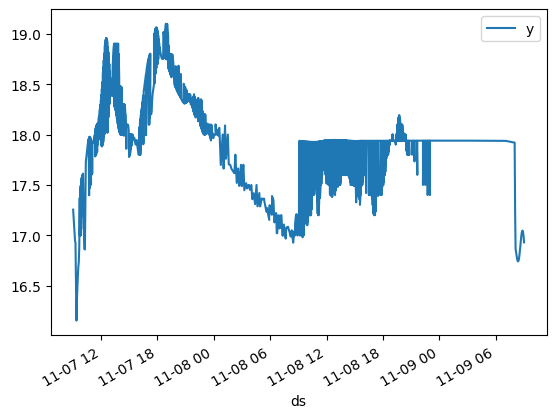

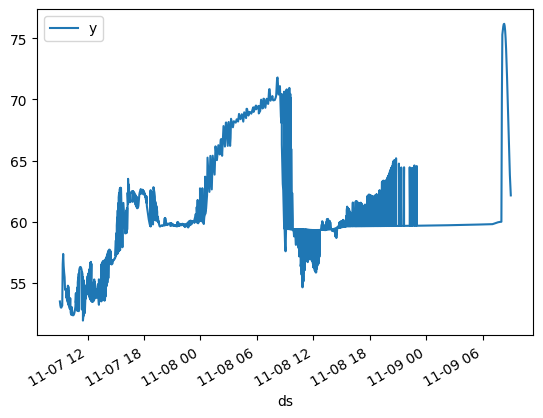

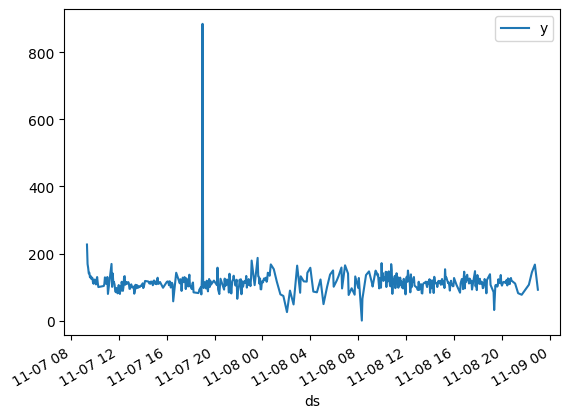

In [44]:
from pandas import DataFrame


def result_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)
    
buckets = ['temperature', 'humidity', 'gas']
dfTemp = DataFrame
dfHum = DataFrame
dfGas = DataFrame

for bucket in buckets:
    query = 'from(bucket: "' + bucket + '")' \
                ' |> range(start: 2022-11-07T09:00:00.00Z, stop: 2022-11-09T09:00:00.00Z)' \
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "'+ bucket + '")' \
                ' |> aggregateWindow(every: 3m, fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    print(result)
    # Convert the results to dataframe
    if (bucket == "temperature" and  result):
        dfTemp = result_to_dataframe(result)
        dfTemp['ds'] = dfTemp['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfTemp[plot_cols]
        plot_features.index = dfTemp['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "humidity" and result):
        dfHum = result_to_dataframe(result)
        dfHum['ds'] = dfHum['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfHum[plot_cols]
        plot_features.index = dfHum['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "gas" and result):
        dfGas = result_to_dataframe(result)
        dfGas['ds'] = dfGas['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfGas[plot_cols]
        plot_features.index = dfGas['ds']
        _ = plot_features.plot(subplots=True)

### Informations about DataFrames. Train and Test Datasets cretion 

In [45]:
trainTemp = DataFrame
testTemp = DataFrame
trainHum= DataFrame
testHum = DataFrame
trainGas = DataFrame
testGas = DataFrame
global tempDate
global humDate
global gasDate

if ( not dfTemp.empty):
    print("Temperature Dataset")    
    print(dfTemp.describe().transpose())
    nrows = (len(dfTemp.values))
    splitPoint = int (nrows * 0.60)
    trainTemp = dfTemp['y'] [:splitPoint]
    testTemp = dfTemp ['y'] [splitPoint:]
    tempDate = dfTemp ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    tempDate['ds'] = tempDate.ds.dt.floor('min')

if (not dfHum.empty):
    print("Humidity Dataset")
    print(dfHum.describe().transpose())
    nrows = (len(dfHum.values))
    splitPoint = int (nrows * 0.60)
    trainHum = dfHum['y'] [:splitPoint]
    testHum = dfHum ['y'] [splitPoint:]
    humDate = dfHum ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    humDate['ds'] = humDate.ds.dt.floor('min')   

if (not dfGas.empty):
    print("Gas Dataset")
    print(dfGas.describe().transpose())
    nrows = (len(dfGas.values))
    splitPoint = int (nrows * 0.60)
    trainGas = dfGas['y'] [:splitPoint]
    testGas = dfGas ['y'] [splitPoint:]
    gasDate = dfGas ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    humDate['ds'] = humDate.ds.dt.floor('min')

Temperature Dataset
    count       mean       std        min        25%        50%        75%  \
y  1237.0  17.918935  0.450137  16.155556  17.777195  17.938629  18.052778   

         max  
y  19.097222  
Humidity Dataset
    count       mean       std        min        25%        50%        75%  \
y  1237.0  59.997536  3.736029  51.916364  59.349871  59.685106  60.447421   

         max  
y  76.176009  
Gas Dataset
   count        mean        std  min         25%         50%         75%  \
y  483.0  114.395033  40.873204  0.0  102.159722  112.583333  123.041667   

          max  
y  885.068966  


### Check if the time-series are stationary using the Dickey-Fuller test

In [46]:
from statsmodels.tsa.stattools import adfuller

resultTemp = 0.0
resultHum = 0.0
resultGas = 0.0

if (not dfTemp.empty):
    resultTemp = adfuller(trainTemp)
    print('TEMPERATURE: ADF Statistic: %f' % resultTemp[0])
    print('TEMPERATURE: p-value: %f' % resultTemp[1])

if (not dfHum.empty):
    resultHum = adfuller(trainHum)
    print('HUMIDITY: ADF Statistic: %f' % resultHum[0])
    print('HUMIDITY: p-value: %f' % resultHum[1])

if (not dfGas.empty):
    resultGas = adfuller(trainGas)
    print('GAS: ADF Statistic: %f' % resultGas[0])
    print('GAS: p-value: %f' % resultGas[1])
    

TEMPERATURE: ADF Statistic: -2.646216
TEMPERATURE: p-value: 0.083817
HUMIDITY: ADF Statistic: -2.037431
HUMIDITY: p-value: 0.270406
GAS: ADF Statistic: -16.037594
GAS: p-value: 0.000000


### If P Value > 0.05 we go ahead with finding the order of differencing.

TEMPERATURE: ADF Statistic: -6.527069
TEMPERATURE: new p-value: 0.000000


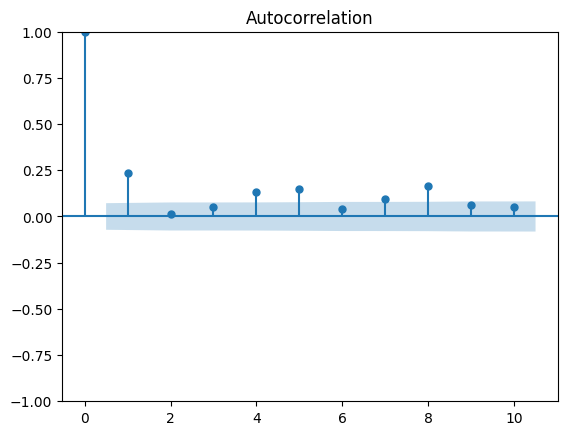

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



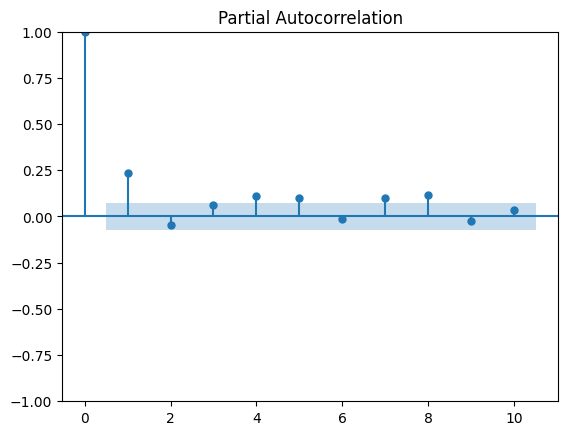

HUMIDITY: ADF Statistic: -15.495105
HUMIDITY: new p-value: 0.000000


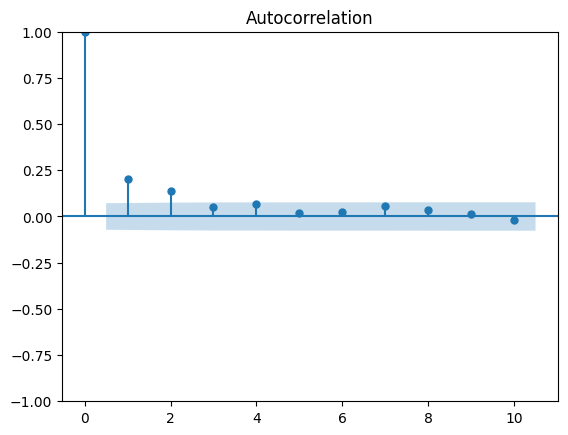

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



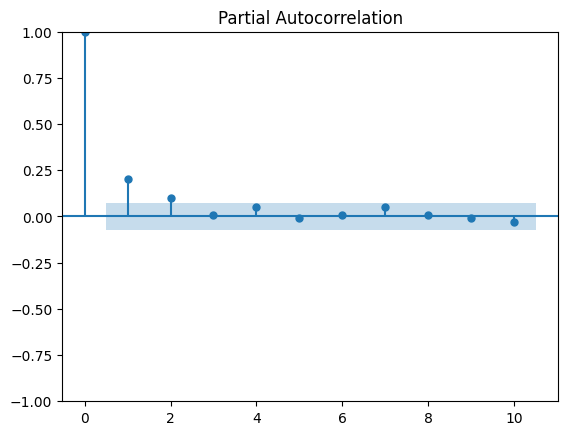

In [48]:
from statsmodels.graphics import tsaplots

if (not dfTemp.empty and resultTemp[1] > 0.05):
    aux = trainTemp
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('TEMPERATURE: ADF Statistic: %f' % result[0])
    print('TEMPERATURE: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfHum.empty and resultHum[1] > 0.05):
    aux = trainHum
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('HUMIDITY: ADF Statistic: %f' % result[0])
    print('HUMIDITY: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfGas.empty and resultGas[1] > 0.05):
    aux = trainGas
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('GAS: ADF Statistic: %f' % result[0])
    print('GAS: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

### Apply ARIMA model to all Datasets

In [52]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error

global temp_model_fit
global hum_model_fit
global gas_model_fit

if (not trainTemp.empty):
  historyTemp = [x for x in trainTemp]
  predictionsTemp = list()
if (not trainHum.empty):
  historyHum = [x for x in trainHum]
  predictionsHum = list()
if (not trainGas.empty):
  historyGas= [x for x in trainGas]
  predictionsGas = list()

if (not dfTemp.empty):
  for t in testTemp.index:
    model = ARIMA(historyTemp, order=(0,0,1))
    temp_model_fit = model.fit()
    output = temp_model_fit.forecast()
    yest = output[0]
    predictionsTemp.append(yest)
    obs= testTemp[t]
    historyTemp.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfHum.empty):
  for t in testHum.index:
    model = ARIMA(historyHum, order=(1,1,1))
    hum_model_fit = model.fit()
    output = hum_model_fit.forecast()
    yest = output[0]
    predictionsHum.append(yest)
    obs= testHum[t]
    historyHum.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfGas.empty):
  for t in testGas.index:
    model = ARIMA(historyGas, order=(1,1,0))
    gas_model_fit = model.fit()
    output = gas_model_fit.forecast()
    yest = output[0]
    predictionsGas.append(yest)
    obs= testGas[t]
    historyGas.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



predicted=17.618704, expected=17.001627
predicted=17.358282, expected=16.996424
predicted=17.602640, expected=16.968421
predicted=17.339529, expected=17.085173
predicted=17.703619, expected=16.993697
predicted=17.265264, expected=16.988222
predicted=17.679763, expected=16.928077
predicted=17.223780, expected=17.023893
predicted=17.751518, expected=17.045601
predicted=17.266894, expected=17.112791
predicted=17.793376, expected=17.202528
predicted=17.376226, expected=17.210227
predicted=17.780429, expected=17.187730
predicted=17.373626, expected=17.184629
predicted=17.756922, expected=17.089311
predicted=17.301501, expected=17.027793
predicted=17.674753, expected=17.937875
predicted=18.183998, expected=17.937082
predicted=17.698772, expected=17.936301
predicted=18.160739, expected=17.935535
predicted=17.718665, expected=17.934791
predicted=18.140926, expected=17.934082
predicted=17.735757, expected=17.933417
predicted=18.123600, expected=17.932808
predicted=17.750878, expected=17.932261


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.927777, expected=17.946114
predicted=17.951517, expected=17.946211
predicted=17.928917, expected=17.946283
predicted=17.950618, expected=17.946325
predicted=17.929916, expected=17.946334
predicted=17.949742, expected=17.946308
predicted=17.930767, expected=17.946248
predicted=17.948876, expected=17.946157


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.931480, expected=17.946039
predicted=17.948023, expected=17.945900
predicted=17.932078, expected=17.945747


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.947200, expected=17.945585
predicted=17.932592, expected=17.945421
predicted=17.946424, expected=17.945259
predicted=17.933048, expected=17.945099
predicted=17.945706, expected=17.944943
predicted=17.933459, expected=17.944788
predicted=17.945041, expected=17.944627
predicted=17.933818, expected=17.944456
predicted=17.944404, expected=17.944266
predicted=17.934106, expected=17.944051
predicted=17.943765, expected=17.943805
predicted=17.934298, expected=17.943523
predicted=17.943098, expected=17.943204
predicted=17.934383, expected=17.942848


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.942392, expected=17.942461
predicted=17.934367, expected=17.942048
predicted=17.941661, expected=17.941620
predicted=17.934280, expected=17.941186
predicted=17.940936, expected=17.940758
predicted=17.934164, expected=17.940346
predicted=17.940257, expected=17.939959
predicted=17.934063, expected=17.939604
predicted=17.939656, expected=17.939284


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.934003, expected=17.939000
predicted=17.939146, expected=17.938749
predicted=17.933989, expected=17.938527
predicted=17.938717, expected=17.938327
predicted=17.934006, expected=17.938142
predicted=17.938341, expected=17.937963
predicted=17.934026, expected=17.937785
predicted=17.937988, expected=17.937601
predicted=17.934024, expected=17.937410
predicted=17.937638, expected=17.937212
predicted=17.933993, expected=17.937009
predicted=17.937290, expected=17.936806
predicted=17.933944, expected=17.936611
predicted=17.936963, expected=17.936432
predicted=17.933905, expected=17.936276
predicted=17.936685, expected=17.936153
predicted=17.933908, expected=17.936068
predicted=17.936486, expected=17.936028
predicted=17.933982, expected=17.936036
predicted=17.936388, expected=17.936094
predicted=17.934143, expected=17.936203
predicted=17.936398, expected=17.936361
predicted=17.934394, expected=17.936569
predicted=17.936512, expected=17.936822
predicted=17.934730, expected=17.937121


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.936210, expected=17.937958
predicted=17.936335, expected=17.937973


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.936233, expected=17.937987
predicted=17.936348, expected=17.938001


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.936256, expected=17.938016
predicted=17.936362, expected=17.938030
predicted=17.936278, expected=17.938045


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.936377, expected=17.938060
predicted=17.936301, expected=17.938074
predicted=17.936387, expected=17.938089
predicted=17.936318, expected=17.938104
predicted=17.936402, expected=17.938119
predicted=17.936339, expected=17.938134
predicted=17.936417, expected=17.938149
predicted=17.936361, expected=17.938165
predicted=17.936433, expected=17.938180
predicted=17.936382, expected=17.938196
predicted=17.936448, expected=17.938211
predicted=17.936403, expected=17.938227
predicted=17.936465, expected=17.938242
predicted=17.936424, expected=17.938258
predicted=17.936482, expected=17.938274
predicted=17.936445, expected=17.938290
predicted=17.936499, expected=17.938306
predicted=17.936466, expected=17.938322
predicted=17.936516, expected=17.938337
predicted=17.936488, expected=17.938353
predicted=17.936534, expected=17.938369
predicted=17.936508, expected=17.938385
predicted=17.936552, expected=17.938401
predicted=17.936529, expected=17.938417
predicted=17.936570, expected=17.938433


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.936662, expected=17.938590
predicted=17.936653, expected=17.938606
predicted=17.936681, expected=17.938621
predicted=17.936672, expected=17.938637
predicted=17.936699, expected=17.938652
predicted=17.936692, expected=17.938667
predicted=17.936716, expected=17.938682
predicted=17.936711, expected=17.938697
predicted=17.936734, expected=17.938712
predicted=17.936730, expected=17.938726


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.936752, expected=17.938741
predicted=17.936749, expected=17.938755
predicted=17.936770, expected=17.938770
predicted=17.936767, expected=17.938784
predicted=17.936787, expected=17.938798
predicted=17.936786, expected=17.938813
predicted=17.936804, expected=17.938827
predicted=17.936804, expected=17.938841
predicted=17.936822, expected=17.938855
predicted=17.936822, expected=17.938868
predicted=17.936839, expected=17.938882
predicted=17.936839, expected=17.938896
predicted=17.936856, expected=17.938909
predicted=17.936857, expected=17.938922
predicted=17.936872, expected=17.938935
predicted=17.936874, expected=17.938948
predicted=17.936889, expected=17.938961
predicted=17.936891, expected=17.938974
predicted=17.936905, expected=17.938987
predicted=17.936908, expected=17.939000
predicted=17.936921, expected=17.939012
predicted=17.936924, expected=17.939025
predicted=17.936938, expected=17.939037
predicted=17.936941, expected=17.939050
predicted=17.936954, expected=17.939063


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.937189, expected=17.939150
predicted=17.937184, expected=17.939137
predicted=17.937180, expected=17.939123
predicted=17.937174, expected=17.939109
predicted=17.937169, expected=17.939095
predicted=17.937164, expected=17.939080
predicted=17.937159, expected=17.939065
predicted=17.937153, expected=17.939050
predicted=17.937147, expected=17.939035
predicted=17.937141, expected=17.939019
predicted=17.937135, expected=17.939003


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.937129, expected=17.938986
predicted=17.937123, expected=17.938969


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.937116, expected=17.938952
predicted=17.937107, expected=17.938935
predicted=17.937100, expected=17.938917
predicted=17.937093, expected=17.938899
predicted=17.937086, expected=17.938880
predicted=17.937078, expected=17.938861
predicted=17.937070, expected=17.938842
predicted=17.937062, expected=17.938822
predicted=17.937054, expected=17.938802
predicted=17.937046, expected=17.938781
predicted=17.937037, expected=17.938761
predicted=17.937028, expected=17.938740
predicted=17.937019, expected=17.938718
predicted=17.937010, expected=17.938696
predicted=17.937001, expected=17.938674
predicted=17.936992, expected=17.938652
predicted=17.936982, expected=17.938629
predicted=17.936972, expected=17.938606
predicted=17.936963, expected=17.938582
predicted=17.936953, expected=17.938558
predicted=17.936942, expected=17.938533
predicted=17.936931, expected=17.938509
predicted=17.936921, expected=17.938483
predicted=17.936909, expected=17.938458
predicted=17.936903, expected=17.938432


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.936829, expected=17.938268
predicted=17.936816, expected=17.938239
predicted=17.936803, expected=17.938210
predicted=17.936790, expected=17.938181
predicted=17.936776, expected=17.938151
predicted=17.936763, expected=17.938120
predicted=17.936746, expected=17.938090
predicted=17.936732, expected=17.938059
predicted=17.936719, expected=17.938027
predicted=17.936704, expected=17.937995
predicted=17.936689, expected=17.937963
predicted=17.936674, expected=17.937931
predicted=17.936659, expected=17.937898


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.936644, expected=17.937865
predicted=17.936629, expected=17.937831
predicted=17.936613, expected=17.937797
predicted=17.936597, expected=17.937763
predicted=17.936581, expected=17.937728
predicted=17.936564, expected=17.937693
predicted=17.936548, expected=17.937657


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.936531, expected=17.937620
predicted=17.936514, expected=17.937583
predicted=17.936496, expected=17.937546
predicted=17.936478, expected=17.937507


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.936460, expected=17.937468
predicted=17.936442, expected=17.937429
predicted=17.936425, expected=17.937389
predicted=17.936406, expected=17.937348
predicted=17.936388, expected=17.937307
predicted=17.936368, expected=17.937266
predicted=17.936348, expected=17.937224
predicted=17.936329, expected=17.937182
predicted=17.936308, expected=17.937139
predicted=17.936288, expected=17.937096
predicted=17.936268, expected=17.937052
predicted=17.936243, expected=17.937004
predicted=17.936218, expected=17.936361
predicted=17.935628, expected=17.935415
predicted=17.935287, expected=17.934442
predicted=17.934681, expected=17.933443
predicted=17.934302, expected=17.932419
predicted=17.933683, expected=17.931379
predicted=17.933277, expected=17.930332
predicted=17.932659, expected=17.929290
predicted=17.932248, expected=17.928265
predicted=17.931655, expected=17.927271
predicted=17.931264, expected=17.926315
predicted=17.930717, expected=17.925405
predicted=17.930364, expected=17.924542


In [53]:
def send_predictions(df, date, bucket):
	lines = [str(df['y'][d]) for d in range(len(df))]
	if(bucket == "gas"):
		lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " gasPred" + '=' + str(df['y'][d])
										+ ' ' + str(int(time.mktime(date['ds'][d].timetuple()))) + "000000000" for d in range(len(date))]
	else:
		lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " " + bucket + '=' + str(df['y'][d])
										+ ' ' + str(int(time.mktime(date['ds'][d].timetuple()))) + "000000000" for d in range(len(date))]
	write_client = client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=10_000,
															jitter_interval=2_000, retry_interval=5_000, write_type=WriteType.synchronous))
	write_client.write(bucket, INFLUXDB_ORG, lines)

### ARIMA model evaluation (RMSE)

Test RMSE: 0.148


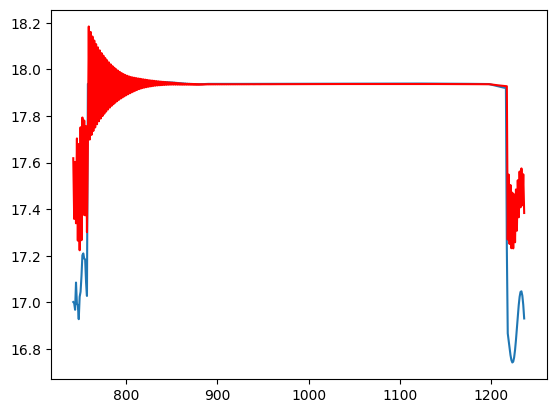

Test RMSE: 0.563


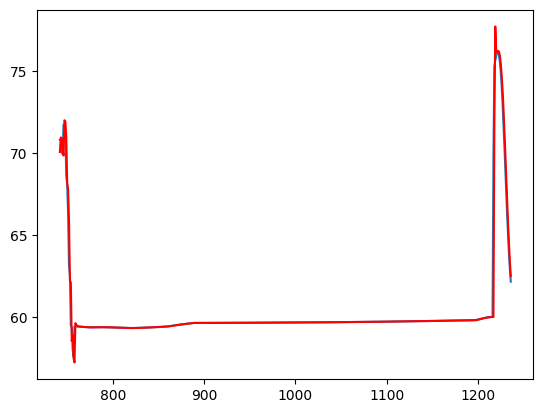

Test RMSE: 20.253


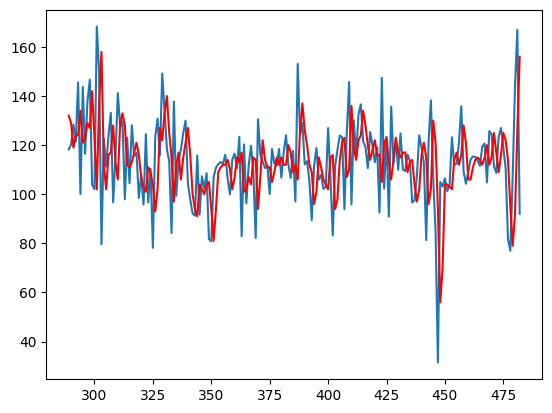

In [54]:
if (not trainTemp.empty):
  rmse = math.sqrt(mean_squared_error(testTemp, predictionsTemp))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsTemp)
  df.columns = ['y']
  send_predictions(df, tempDate, "temperature")
  df.set_index(testTemp.index, inplace=True)
  plt.plot(testTemp)
  plt.plot(df, color='red')
  plt.show()

if (not trainHum.empty):
  rmse = math.sqrt(mean_squared_error(testHum, predictionsHum))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsHum)
  df.columns = ['y']
  send_predictions(df, humDate, "humidity")
  df.set_index(testHum.index, inplace=True)
  plt.plot(testHum)
  plt.plot(df, color='red')
  plt.show()
  
if (not trainGas.empty):
  rmse = math.sqrt(mean_squared_error(testGas, predictionsGas))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsGas)
  df.columns = ['y']
  df["y"] = df["y"].astype(int)
  send_predictions(df, gasDate, "gas")
  df.set_index(testGas.index, inplace=True)
  plt.plot(testGas)
  plt.plot(df, color='red')
  plt.show()

### Evaluation

In [55]:
#Temperature evaluation
temp_forecast = temp_model_fit.get_forecast()
temp_forecast.summary_frame()
yhat = temp_forecast.predicted_mean
yhat_conf_int = temp_forecast.conf_int(alpha=0.05)

print('Temperature Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))

#Temperature evaluation
hum_forecast = hum_model_fit.get_forecast()
hum_forecast.summary_frame()
yhat = hum_forecast.predicted_mean
yhat_conf_int = hum_forecast.conf_int(alpha=0.05)

print('Humidity Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))

#Temperature evaluation
gas_forecast = gas_model_fit.get_forecast()
gas_forecast.summary_frame()
yhat = gas_forecast.predicted_mean
yhat_conf_int = gas_forecast.conf_int(alpha=0.05)

print('Gas Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))



Temperature Model Evaluation Summary:
----------------------------------------
Mean: [17.38367556]
Confidence Interval: [[16.9158077  17.85154342]]
Humidity Model Evaluation Summary:
----------------------------------------
Mean: [62.49591983]
Confidence Interval: [[61.39925605 63.5925836 ]]
Gas Model Evaluation Summary:
----------------------------------------
Mean: [156.27131548]
Confidence Interval: [[ 59.8166387  252.72599225]]
